In [1]:
import zipfile
from glob import glob
import os
from netCDF4 import Dataset
import pandas as pd
import geopandas as gpd # GeoPandas(지오판다스)
from shapely.geometry import Polygon, LineString, Point
path = os.getcwd()

import rasterio
from rasterio.plot import show
from rasterio.transform import from_origin
import matplotlib.pyplot as plt

import numpy as np

import requests
import time

from geocube.api.core import make_geocube
import seaborn as sns

from tqdm import tqdm

import tensorflow as tf
from tensorflow.python.client import device_lib

print(tf.__version__)
print(device_lib.list_local_devices())

2.8.0
[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 17454675120861498514
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 3645898752
locality {
  bus_id: 1
  links {
  }
}
incarnation: 1309401020596195013
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 3060 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6"
xla_global_id: 416903419
]


In [2]:
path

'c:\\Users\\Go\\OneDrive - UOS\\allrepos\\UNet-project (2)'

## 데이터셋 생성

* 데이터셋 window 설정 점검

In [ ]:
def _bytes_feature(value):
    """Returns a bytes_list from a string / byte."""
    if isinstance(value, type(tf.constant(0))):
        value = value.numpy() # BytesList won't unpack a string from an EagerTensor.
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))


def _parse_function(tfrecord_serialized):
    features={
        'CMAQ_t': tf.io.FixedLenFeature([], tf.string),
        'SMOKE_t': tf.io.FixedLenFeature([], tf.string),
        'air_quality_monitoring_t': tf.io.FixedLenFeature([], tf.string),
        'weather_monitoring_t': tf.io.FixedLenFeature([], tf.string),
        'year': tf.io.FixedLenFeature([], tf.string),
        'month': tf.io.FixedLenFeature([], tf.string),
        'day': tf.io.FixedLenFeature([], tf.string),
        'hour': tf.io.FixedLenFeature([], tf.string),
             }
    parsed_features = tf.io.parse_single_example(tfrecord_serialized, features)
    
    cmaq = tf.io.decode_raw(parsed_features['CMAQ_t'], tf.float32)
    smoke = tf.io.decode_raw(parsed_features['SMOKE_t'], tf.float32)
    aq = tf.io.decode_raw(parsed_features['air_quality_monitoring_t'], tf.float64)  #이것 둘 64로 저장됨
    weather = tf.io.decode_raw(parsed_features['weather_monitoring_t'], tf.float64)
    year = tf.io.decode_raw(parsed_features['year'], tf.uint8)
    month = tf.io.decode_raw(parsed_features['month'], tf.uint8)
    day = tf.io.decode_raw(parsed_features['day'], tf.uint8)
    hour = tf.io.decode_raw(parsed_features['hour'], tf.uint8)

  

    cmaq = tf.reshape(cmaq, [82, 67, 1])
    print(cmaq.shape)
    smoke = tf.reshape(smoke, [82, 67, 45])
    print(smoke.shape)
    aq = tf.reshape(aq, [82, 67, 1])
    print(aq.shape)
    weather = tf.reshape(weather, [82, 67, 15])
    print(weather.shape)
    
    year = tf.squeeze(year)
    month = tf.squeeze(month)
    day = tf.squeeze(day)
    hour = tf.squeeze(hour)

    
    # image = tf.io.decode_raw(parsed_features['image'], tf.uint8)
    # image = tf.reshape(image, [IMG_SIZE, IMG_SIZE, 3])


    # classes = tf.io.decode_raw(parsed_features['classes'], tf.uint8)    
    # classes = tf.squeeze(classes)
    tf.cast(cmaq,tf.float32)

    return cmaq, smoke, aq, weather, year, month, day, hour

In [136]:
BATCH_SIZE = 5
window_size = 5
shift = 1
# exam_dataset = tf.data.TFRecordDataset(os.path.join("e:",'dataset_105.tfr'))
# exam_dataset = tf.data.TFRecordDataset([os.path.join(path,"dataset_record",'dataset_105.tfr'),os.path.join(path,"dataset_record",'dataset_106.tfr'),])
exam_dataset = tf.data.TFRecordDataset(os.path.join(path,"dataset_record",'dataset_105.tfr'))
exam_dataset = exam_dataset.map(_parse_function, num_parallel_calls=tf.data.experimental.AUTOTUNE)
# exam_dataset = exam_dataset.prefetch(tf.data.experimental.AUTOTUNE).window(5, shift=1, drop_remainder = True).batch(BATCH_SIZE)
exam_dataset = exam_dataset.prefetch(tf.data.experimental.AUTOTUNE).window(window_size, shift=shift, drop_remainder = True)
# exam_dataset = exam_dataset.flat_map(lambda window: window.batch(input_width))
def get_cmaq_window(x1,x2,x3,x4,x5,x6,x7,x8,):
    return x1.batch(window_size, drop_remainder=True)

def get_smoke_window(x1,x2,x3,x4,x5,x6,x7,x8,):
    return x2.batch(window_size, drop_remainder=True)

def get_time_window(x1,x2,x3,x4,x5,x6,x7,x8,):
    return x8.batch(window_size, drop_remainder=True)

def dense_step_input(input_batch):
  # Shift features and labels one step relative to each other.
  return input_batch[:-1]

def dense_step_target(target_batch):
  # Shift features and labels one step relative to each other.
  return target_batch[-1:]



exam_dataset_cmaq = exam_dataset.flat_map(get_cmaq_window)
target_cmaq = exam_dataset_cmaq.map(dense_step_target)

exam_dataset_smoke = exam_dataset.flat_map(get_smoke_window)
input_smoke = exam_dataset_cmaq.map(dense_step_input)

exam_dataset_smoke_time = exam_dataset.flat_map(get_time_window)
input_smoke_time = exam_dataset_smoke_time.map(dense_step_input)

exam_dataset_cmaq_time = exam_dataset.flat_map(get_time_window)
target_cmaq_time = exam_dataset_cmaq_time.map(dense_step_target)


(82, 67, 1)
(82, 67, 45)
(82, 67, 1)
(82, 67, 15)


In [137]:
for example in target_cmaq.take(5):
  print(example.shape)


(1, 82, 67, 1)
(1, 82, 67, 1)
(1, 82, 67, 1)
(1, 82, 67, 1)
(1, 82, 67, 1)


In [138]:
for example in input_smoke.take(5):
  print(example.shape)

(4, 82, 67, 1)
(4, 82, 67, 1)
(4, 82, 67, 1)
(4, 82, 67, 1)
(4, 82, 67, 1)


In [141]:
for example in input_smoke_time.take(5):
  print(example)

tf.Tensor(
[[0 0 0 0]
 [1 0 0 0]
 [2 0 0 0]
 [3 0 0 0]], shape=(4, 4), dtype=uint8)
tf.Tensor(
[[1 0 0 0]
 [2 0 0 0]
 [3 0 0 0]
 [4 0 0 0]], shape=(4, 4), dtype=uint8)
tf.Tensor(
[[2 0 0 0]
 [3 0 0 0]
 [4 0 0 0]
 [5 0 0 0]], shape=(4, 4), dtype=uint8)
tf.Tensor(
[[3 0 0 0]
 [4 0 0 0]
 [5 0 0 0]
 [6 0 0 0]], shape=(4, 4), dtype=uint8)
tf.Tensor(
[[4 0 0 0]
 [5 0 0 0]
 [6 0 0 0]
 [7 0 0 0]], shape=(4, 4), dtype=uint8)


In [142]:
for example in target_cmaq_time.take(5):
  print(example)

tf.Tensor([[4 0 0 0]], shape=(1, 4), dtype=uint8)
tf.Tensor([[5 0 0 0]], shape=(1, 4), dtype=uint8)
tf.Tensor([[6 0 0 0]], shape=(1, 4), dtype=uint8)
tf.Tensor([[7 0 0 0]], shape=(1, 4), dtype=uint8)
tf.Tensor([[8 0 0 0]], shape=(1, 4), dtype=uint8)


In [143]:
zip_ds = tf.data.Dataset.zip((input_smoke_time, target_cmaq_time))

In [144]:
for exam in zip_ds.batch(5).take(1):
    break

In [146]:
exam[0]

<tf.Tensor: shape=(5, 4, 4), dtype=uint8, numpy=
array([[[0, 0, 0, 0],
        [1, 0, 0, 0],
        [2, 0, 0, 0],
        [3, 0, 0, 0]],

       [[1, 0, 0, 0],
        [2, 0, 0, 0],
        [3, 0, 0, 0],
        [4, 0, 0, 0]],

       [[2, 0, 0, 0],
        [3, 0, 0, 0],
        [4, 0, 0, 0],
        [5, 0, 0, 0]],

       [[3, 0, 0, 0],
        [4, 0, 0, 0],
        [5, 0, 0, 0],
        [6, 0, 0, 0]],

       [[4, 0, 0, 0],
        [5, 0, 0, 0],
        [6, 0, 0, 0],
        [7, 0, 0, 0]]], dtype=uint8)>

In [147]:
exam[1]

<tf.Tensor: shape=(5, 1, 4), dtype=uint8, numpy=
array([[[4, 0, 0, 0]],

       [[5, 0, 0, 0]],

       [[6, 0, 0, 0]],

       [[7, 0, 0, 0]],

       [[8, 0, 0, 0]]], dtype=uint8)>

* 학습-검증셋 준비

In [3]:
def _parse_function2(tfrecord_serialized):
    features={
        'CMAQ_t': tf.io.FixedLenFeature([], tf.string),
        'SMOKE_t': tf.io.FixedLenFeature([], tf.string),
        'air_quality_monitoring_t': tf.io.FixedLenFeature([], tf.string),
        'weather_monitoring_t': tf.io.FixedLenFeature([], tf.string),
        # 'year': tf.io.FixedLenFeature([], tf.string),
        # 'month': tf.io.FixedLenFeature([], tf.string),
        # 'day': tf.io.FixedLenFeature([], tf.string),
        # 'hour': tf.io.FixedLenFeature([], tf.string),
             }
    parsed_features = tf.io.parse_single_example(tfrecord_serialized, features)
    
    cmaq = tf.io.decode_raw(parsed_features['CMAQ_t'], tf.float32)
    # 12년 측정망자료로 나중에 정규화 해주기
    smoke = tf.io.decode_raw(parsed_features['SMOKE_t'], tf.float32)
    aq = tf.io.decode_raw(parsed_features['air_quality_monitoring_t'], tf.float64)  #이것 둘 64로 저장됨
    # 바람 방향 x, y벡터랑 강도로 뽑는작업 나중에 하기
    weather = tf.io.decode_raw(parsed_features['weather_monitoring_t'], tf.float64)
    # year = tf.io.decode_raw(parsed_features['year'], tf.uint8)
    # 월 sin함수 주기로 바꾸어서 넣어주기
    # month = tf.io.decode_raw(parsed_features['month'], tf.uint8)
    # 일 sin함수 주기로 바꾸어서 넣어주기
    # day = tf.io.decode_raw(parsed_features['day'], tf.uint8)
    # hour = tf.io.decode_raw(parsed_features['hour'], tf.uint8)

  

    cmaq = tf.reshape(cmaq, [82, 67, 1])
    # print(cmaq.shape)
    smoke = tf.reshape(smoke, [82, 67, 45])
    # print(smoke.shape)
    aq = tf.reshape(aq, [82, 67, 1])
    # # print(aq.shape)
    weather = tf.reshape(weather, [82, 67, 15])
    # print(weather.shape)
    
    # year = tf.squeeze(year)
    # month = tf.squeeze(month)
    # day = tf.squeeze(day)
    # hour = tf.squeeze(hour)

    
    # image = tf.io.decode_raw(parsed_features['image'], tf.uint8)
    # image = tf.reshape(image, [IMG_SIZE, IMG_SIZE, 3])


    # classes = tf.io.decode_raw(parsed_features['classes'], tf.uint8)    
    # classes = tf.squeeze(classes)
    # tf.cast(cmaq,tf.float32)
    # tf.concat([tf.cast(smoke,tf.float32),tf.cast(aq,tf.float32),tf.cast(weather,tf.float32),], axis=3)
    # tf.concat([tf.cast(smoke,tf.float32),tf.cast(aq,tf.float32),tf.cast(weather,tf.float32),], axis=2)[8:-10,2:-1,:]
    # return cmaq[8:-10,2:-1,:], tf.cast(smoke,tf.float32)[8:-10,2:-1,:], year, month, day, hour
    # return smoke[8:-10,2:-1,:],cmaq[8:-10,2:-1,:]
    # return smoke,cmaq
    return tf.concat([tf.cast(smoke,tf.float32),tf.cast(aq,tf.float32),tf.cast(weather,tf.float32),], axis=2)[8:-10,2:-1,:], cmaq[8:-10,2:-1,:]

In [4]:
all_tfr_path = glob(os.path.join(path,"dataset_record",'*.tfr'))
train_len = round(len(all_tfr_path) * 0.8)

train_tfr_path = list(np.random.choice(all_tfr_path,train_len, replace=False))

test_tfr_path = list(set(all_tfr_path) - set(train_tfr_path))
val_tfr_path = list(np.random.choice(test_tfr_path,1, replace=False))
test_tfr_path = list(set(test_tfr_path) - set(val_tfr_path))

print("trainset_n: ", train_len, "valset_n: ", len(val_tfr_path), "testset_n: ", len(test_tfr_path))

trainset_n:  6 valset_n:  1 testset_n:  1


In [5]:
BATCH_SIZE = 4
EPOCH = 10
# N_RUN = 1000

input_width = 24
target_width = 1
window_size = input_width + target_width
shift = 1

def get_target_window(x1,x2):
    return x2.batch(window_size, drop_remainder=True)

def get_input_window(x1,x2):
    return x1.batch(window_size, drop_remainder=True)

def dense_step_input(input_batch):
  # Shift features and labels one step relative to each other.
  return input_batch[:-1]

def dense_step_target(target_batch):
  # Shift features and labels one step relative to each other.
  return target_batch[-1:]

In [6]:
# 학습셋, 셔플 x일단, 정규화도 x 나중에 12년도 데이터 사용해서 스케일링할것
train_dataset = tf.data.TFRecordDataset(train_tfr_path)
train_dataset = train_dataset.map(_parse_function2, num_parallel_calls=tf.data.experimental.AUTOTUNE)
train_dataset = train_dataset.prefetch(tf.data.experimental.AUTOTUNE).window(window_size, shift=shift, drop_remainder = True)

train_dataset_cmaq = train_dataset.flat_map(get_target_window)
train_target = train_dataset_cmaq.map(dense_step_target)

train_dataset_smoke = train_dataset.flat_map(get_input_window)
train_input = train_dataset_smoke.map(dense_step_input)

train_ds = tf.data.Dataset.zip((train_input, train_target)).batch(BATCH_SIZE).shuffle(1000)

In [7]:
# 검증셋, 셔플 x일단, 정규화도 x 나중에 12년도 데이터 사용해서 스케일링할것
val_dataset = tf.data.TFRecordDataset(val_tfr_path)
val_dataset = val_dataset.map(_parse_function2, num_parallel_calls=tf.data.experimental.AUTOTUNE)
val_dataset = val_dataset.prefetch(tf.data.experimental.AUTOTUNE).window(window_size, shift=shift, drop_remainder = True)

val_dataset_cmaq = val_dataset.flat_map(get_target_window)
val_target = val_dataset_cmaq.map(dense_step_target)

val_dataset_smoke = val_dataset.flat_map(get_input_window)
val_input = val_dataset_smoke.map(dense_step_input)

val_ds = tf.data.Dataset.zip((val_input, val_target)).batch(BATCH_SIZE).shuffle(1000)

In [8]:
# 검증셋, 셔플 x일단, 정규화도 x 나중에 12년도 데이터 사용해서 스케일링할것
test_dataset = tf.data.TFRecordDataset(test_tfr_path)
test_dataset = test_dataset.map(_parse_function2, num_parallel_calls=tf.data.experimental.AUTOTUNE)
test_dataset = test_dataset.prefetch(tf.data.experimental.AUTOTUNE).window(window_size, shift=shift, drop_remainder = True)

test_dataset_cmaq = test_dataset.flat_map(get_target_window)
test_target = test_dataset_cmaq.map(dense_step_target)

test_dataset_smoke = test_dataset.flat_map(get_input_window)
test_input = test_dataset_smoke.map(dense_step_input)

test_ds = tf.data.Dataset.zip((test_input, test_target)).batch(BATCH_SIZE).shuffle(1000)

## 모델 학습

In [9]:
INPUT_SHAPE = [input_width, 64, 64, 61]

OUTPUT_CHANNELS = 1

def downsample(filters, size, apply_batchnorm=True):
  initializer = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential()
  result.add(
      tf.keras.layers.Conv2D(filters, size, strides=2, padding='same',
                             kernel_initializer=initializer, use_bias=False))

  if apply_batchnorm:
    result.add(tf.keras.layers.BatchNormalization())

  result.add(tf.keras.layers.LeakyReLU())

  return result

def upsample(filters, size, apply_dropout=False):
  initializer = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential()
  result.add(
    tf.keras.layers.Conv2DTranspose(filters, size, strides=2,
                                    padding='same',
                                    kernel_initializer=initializer,
                                    use_bias=False))

  result.add(tf.keras.layers.BatchNormalization())

  if apply_dropout:
      result.add(tf.keras.layers.Dropout(0.5))

  result.add(tf.keras.layers.ReLU())

  return result

def LSTM2d_Unet():
  # data_augmentation = tf.keras.Sequential([
  #   # tf.keras.layers.RandomFlip('horizontal'), # "horizontal", "vertical", or "horizontal_and_vertical"
  #   # tf.keras.layers.RandomRotation(0.2),
  #   tf.keras.layers.GaussianNoise(   # 노이즈레이어 이부분도 학습에서만 활성화됨
  #       1, seed=None,
  #   )
  #   ])




  inputs = tf.keras.layers.Input(shape=INPUT_SHAPE)


  conv_lstm2d = tf.keras.layers.ConvLSTM2D(64, kernel_size=3, padding='same')

  down_stack = [
    downsample(64, 3),  # (batch_size, 64, 64, 64)
    downsample(128, 3),  # (batch_size, 32, 32, 128)
    downsample(256, 3),  # (batch_size, 16, 16, 256)
    downsample(512, 3),  # (batch_size, 8, 8, 512)
    downsample(512, 3),  # (batch_size, 4, 4, 512)
  ]

  up_stack = [
    upsample(512, 3, apply_dropout=True),  # (batch_size, 4, 4, 1024)
    upsample(512, 3),  # (batch_size, 8, 8, 1024)
    upsample(256, 3),  # (batch_size, 16, 16, 512)
    upsample(128, 3),  # (batch_size, 32, 32, 256)
    upsample(64, 3),  # (batch_size, 64, 64, 128)
  ]

  initializer = tf.random_normal_initializer(0., 0.02)
  last = tf.keras.layers.Conv2DTranspose(OUTPUT_CHANNELS, 2,
                                         strides=2,
                                         padding='same',
                                         kernel_initializer=initializer,
                                         )  # (batch_size, 256, 256, 3)  activation='tanh'

  x = inputs
  x = conv_lstm2d(x)


  # x = data_augmentation(x)      

  # Downsampling through the model
  skips = []
  for down in down_stack:
    x = down(x)
    skips.append(x)

  skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
  for up, skip in zip(up_stack, skips):
    x = up(x)
    x = tf.keras.layers.Concatenate()([x, skip])

  x = last(x)

  return tf.keras.Model(inputs=inputs, outputs=x)

In [10]:
net_surrogate = LSTM2d_Unet()

In [11]:
loss = tf.keras.losses.MeanSquaredError()
optimizer = tf.keras.optimizers.Adam(0.0001)

net_surrogate.compile(
    optimizer = optimizer,
    loss = loss,
    # metrics = ['mse', 'rmse']
)
net_surrogate.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 24, 64, 64,  0           []                               
                                 61)]                                                             
                                                                                                  
 conv_lstm2d (ConvLSTM2D)       (None, 64, 64, 64)   288256      ['input_1[0][0]']                
                                                                                                  
 sequential (Sequential)        (None, 32, 32, 64)   37120       ['conv_lstm2d[0][0]']            
                                                                                                  
 sequential_1 (Sequential)      (None, 16, 16, 128)  74240       ['sequential[0][0]']         

In [12]:
history = net_surrogate.fit(
  train_ds,
  validation_data=val_ds,
  epochs=EPOCH
)

Epoch 1/10
3657/3657 [==============================] - 1891s 489ms/step - loss: 236.4359 - val_loss: 163.4152
Epoch 2/10
3657/3657 [==============================] - 1877s 490ms/step - loss: 157.9026 - val_loss: 153.4629
Epoch 3/10
3657/3657 [==============================] - 2097s 550ms/step - loss: 143.3680 - val_loss: 154.5703
Epoch 4/10
3657/3657 [==============================] - 2143s 563ms/step - loss: 128.5939 - val_loss: 151.6713
Epoch 5/10
3657/3657 [==============================] - 2162s 568ms/step - loss: 117.8135 - val_loss: 147.8860
Epoch 6/10
3657/3657 [==============================] - 2115s 555ms/step - loss: 108.5734 - val_loss: 149.3147
Epoch 7/10
3657/3657 [==============================] - 2133s 560ms/step - loss: 103.3493 - val_loss: 143.8116
Epoch 8/10
3657/3657 [==============================] - 2125s 558ms/step - loss: 98.9671 - val_loss: 138.8366
Epoch 9/10
3657/3657 [==============================] - 2138s 561ms/step - loss: 96.6499 - val_loss: 139.5599
Epo

UnicodeDecodeError: 'utf-8' codec can't decode byte 0xbe in position 82: invalid start byte

In [13]:
net_surrogate.save_weights('checkpoint_1')

UnicodeDecodeError: 'utf-8' codec can't decode byte 0xbe in position 82: invalid start byte

## 평가

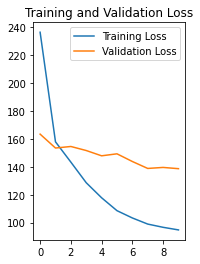

In [14]:
# 일단 val_set만 활용, 
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCH)

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [15]:
predictions = net_surrogate.predict(test_ds)

In [29]:
predictions.shape

(2904, 64, 64, 1)

ValueError: num must be 1 <= num <= 100, not 101

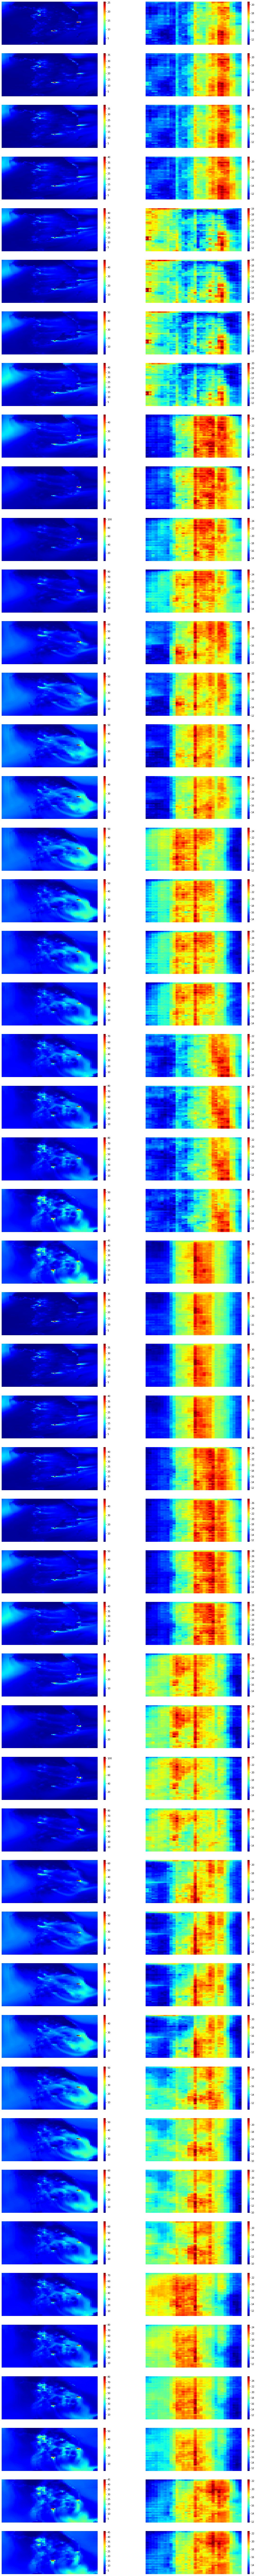

In [37]:
fig = plt.figure(figsize=(20,200))
count_1 = 0
count_2 = 1
count_3 = 0
for batch in test_dataset.take(50):

    for var in batch[1]:
        true = var.numpy().reshape(64,64)
        plt.subplot(50, 2, count_1+1)
        sns.heatmap(true[::-1], cmap = 'jet')
        plt.axis('off')

        plt.subplot(50, 2, count_2+1)
        sns.heatmap(predictions[count_3].reshape(64,64)[::-1], cmap = 'jet')
        plt.axis('off')

        count_1 += 2
        count_2 += 2
        count_3 += 1
    

In [28]:
true.shape

(64, 64)